In [53]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import wordcloud, re, string
import gensim
from gensim.models import Word2Vec, KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import keras_core as keras
import keras_nlp
from transformers import BertTokenizer, BertForSequenceClassification
import keras
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/word2vec/GoogleNews-vectors-negative300.bin
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/word2vec-file/GoogleNews-vectors-negative300.bin


# Introduction 

## Problem

This notebook tried to build a nlp model to identify whether a tweet is reporting a real disaster or not. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). A precise model which can correctly label a tweet as 1(disaster) or 0(not disaster) could literally be a life saver. Since this task involoves anlysizing sequential data(tweets content), we will consider using RNN and pretrained Transformer to build our model.

## Data

The train data set for this problem has shape(7613, 5), including 5 columns: id, text, location, keyword, and target. At the same time, the test data set has shape(3263, 4), including id, text, location, and keyword.

# Exploratory Data Analysis (EDA)

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

## Load Data

In [2]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(train.shape))
print('Test Set Shape = {}'.format(test.shape))


Training Set Shape = (7613, 5)
Test Set Shape = (3263, 4)


## Inspect and Explore Data

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
train[train['target'] == 1].loc[0]['text']

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [13]:
train[train['target'] == 0].loc[15]['text']

"What's up man?"

### Check Null Value

In [6]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

Only id and text columns have all values. We will build our model on anlysizing "text" column.

### Check Duplicate Value

In [3]:
train['text'].duplicated().sum()


110

There are 110 duplicated texts in the train set.

In [4]:
grouped = train.groupby('text')['target'].agg(['count', 'nunique'])
inconsistent_groups = grouped[grouped['nunique'] > 1]
if not inconsistent_groups.empty:
    print("Inconsistent groups found:")
    print(inconsistent_groups)
else:
    print("All duplicate texts have consistent targets.")

Inconsistent groups found:
                                                    count  nunique
text                                                              
#Allah describes piling up #wealth thinking it ...      3        2
#foodscare #offers2go #NestleIndia slips into l...      3        2
.POTUS #StrategicPatience is a strategy for #Ge...      4        2
CLEARED:incident with injury:I-495  inner loop ...      3        2
Caution: breathing may be hazardous to your hea...      2        2
He came to a land which was engulfed in tribal ...      6        2
Hellfire is surrounded by desires so be careful...      3        2
Hellfire! We donÛªt even want to think about i...      2        2
I Pledge Allegiance To The P.O.P.E. And The Bur...      2        2
In #islam saving a person is equal in reward to...      2        2
Mmmmmm I'm burning.... I'm burning buildings I'...      2        2
RT NotExplained: The only known image of infamo...      2        2
The Prophet (peace be upon him) sai

Saddly, there are some tweets that have same texts and different targets. These data will confuse our model, so we better clean them out.

In [5]:
# clear inconsistent data
train = train[~train['text'].isin(inconsistent_groups.index)]
# drop consistent duplicated data
train.drop_duplicates(subset='text', inplace=True)
# check duplicated text again
train['text'].duplicated().sum()


0

In [8]:
test.duplicated().sum()

0

## Clean Data

In [6]:
def clean(x):
    x = x.lower()
    x = x.translate(str.maketrans('', '', string.punctuation))
    x = ' '.join([i for i in x.split() if i not in wordcloud.STOPWORDS])
    x = ' '.join([i for i in x.split() if i.isalpha()])
    x = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())
    return x

In [7]:
train['text'] = train['text'].apply(clean)

In [8]:
train['text'][10]

'three people died heat wave far'

### Check Data Distribution

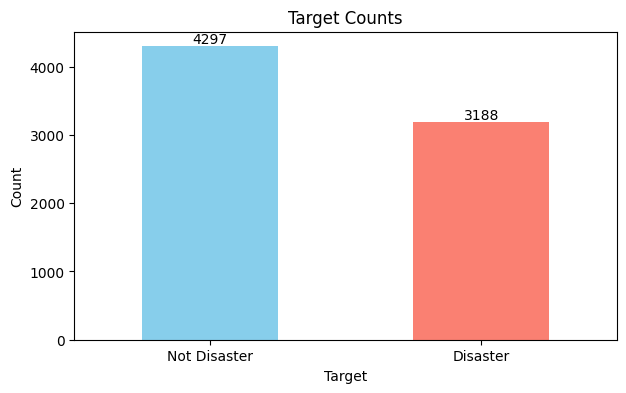

In [26]:
target_counts = train['target'].value_counts()

plt.figure(figsize=(7, 4))
bars=target_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Target Counts')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'], rotation=0)
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2,  
             bar.get_height(),                  
             int(bar.get_height()),             
             ha='center',                       
             va='bottom')    
plt.show()

Our data is roughly balanced.

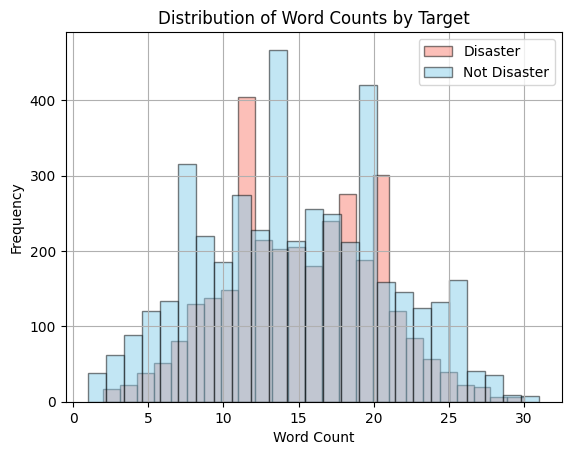

In [27]:
train['word_count'] = train['text'].apply(lambda x: len([word for word in x.split() if word]))

plt.hist(train[train['target'] == 1]['word_count'], bins=25, alpha=0.5, label='Disaster', color='salmon', edgecolor='black')
plt.hist(train[train['target'] == 0]['word_count'], bins=25, alpha=0.5, label='Not Disaster', color='skyblue', edgecolor='black')

plt.title('Distribution of Word Counts by Target')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()

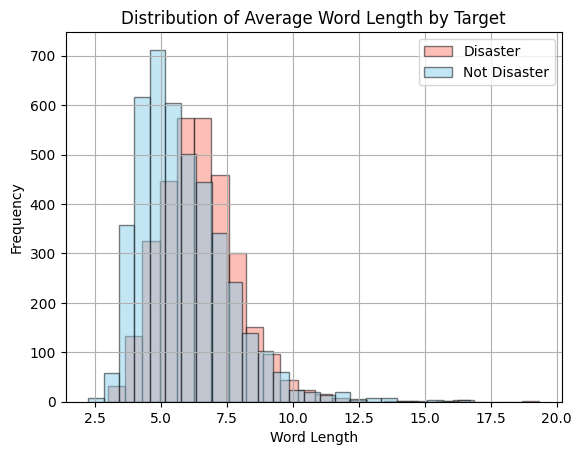

In [28]:
train['avg_word_len'] = train['text'].apply(lambda x: sum([len(word) for word in x.split()]) / len(x.split()))

plt.hist(train[train['target'] == 1]['avg_word_len'], bins=25, alpha=0.5, label='Disaster', color='salmon', edgecolor='black')
plt.hist(train[train['target'] == 0]['avg_word_len'], bins=25, alpha=0.5, label='Not Disaster', color='skyblue', edgecolor='black')

plt.title('Distribution of Average Word Length by Target')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()

The distributions of words count and average words length among disaster and not disaster data set are basically similar.

# Model Architecture

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.). 

## Prepare Data(Word Embedding)

Before we build our model learn tweets texts, we need to convert text data to vector representation for efficiency and better performance. Here I choose to use **Word2Vec**

Word2Vec is a popular way to embed vocabulary as it can capture the similarity of words. Words used in similar contexts or having semantic relationships are captured effectively through their closeness in the vector space- effectively speaking similar words will have similar word vectors! For example, the context 1 is "I like orange juice." the context 2 is "I also like to drink apple juice". By learning above 2 contexts, word2vec model will realize the distance between "orange" and "apple" should be closer than "orange" and "human". As the result, the vector of "orange" will be similar with the vector of "apple"

For this perticular disaster tweet classification task, the words to help human identify if a tweet is about a real disaster usually are similar, like earthquaks, hurricane, fire.etc. Word2Vec can help our model to learn those synonymous words, then hopefully better detect if a tweet is reporting a disaster.

In [24]:
# import gensim.downloader
# list(gensim.downloader.info()['models'].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

In [ ]:
# w2c = gensim.downloader.load('word2vec-google-news-300')


[=============================================-----] 90.9% 1512.0/1662.8MB downloaded

In [8]:
%%time
w2v_path = '/kaggle/input/word2vec/GoogleNews-vectors-negative300.bin' 
w2v_model = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

CPU times: user 49.2 s, sys: 7.31 s, total: 56.5 s
Wall time: 1min 22s


In [35]:
w2v_model.most_similar("earthquake")


[('quake', 0.911206066608429),
 ('#.#_magnitude_earthquake', 0.8794152140617371),
 ('#.#_magnitude_quake', 0.8228378295898438),
 ('temblor', 0.8145468235015869),
 ('devastating_earthquake', 0.8075742721557617),
 ('earthquakes', 0.7766882181167603),
 ('quakes', 0.7350267767906189),
 ('aftershock', 0.733711838722229),
 ('magnitude_earthquake', 0.7275098562240601),
 ('Earthquake', 0.7246856689453125)]

In [9]:
%%time
texts = train['text'].astype(str).tolist()
targets = train['target'].tolist()

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

# Pad sequences to ensure uniform length
max_length = max(len(seq) for seq in sequences)
data = pad_sequences(sequences)

# Prepare Embedding Matrix
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in w2v_model:
        embedding_matrix[i] = w2v_model[word]


CPU times: user 510 ms, sys: 41.9 ms, total: 552 ms
Wall time: 551 ms


In [10]:
# check embedding matrix
print(embedding_matrix.shape)
data.shape


(16821, 300)


(7485, 24)

## Base Model

We first try a simple RNN model as a baseline. A base model can help us understand how RNN performances on this task. The simple base model will use long short term memory(LSTM). LSTM enables our model to remember longer context and hopefully learn a real disaster tweet context looks like better as well.

Architecture: embedding + LSTM(units=128, dropout=0.2, recurrent_dropout=0.2) + Dense(units=1, activation='sigmoid')

In [11]:
model = Sequential()
model.add(Input(shape = (data.shape[1],))),
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=data.shape[1], trainable=False))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 24, 300)        │     5,046,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,266,077 (20.09 MB)

 Trainable params: 219,777 (858.50 KB)

 Non-trainable params: 5,046,300 (19.25 MB)

In [12]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(data, np.array(targets), epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.6959 - loss: 0.5602 - val_accuracy: 0.7996 - val_loss: 0.4561
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8096 - loss: 0.4459 - val_accuracy: 0.8029 - val_loss: 0.4430
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8077 - loss: 0.4408 - val_accuracy: 0.8210 - val_loss: 0.4235
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8052 - loss: 0.4311 - val_accuracy: 0.8143 - val_loss: 0.4294
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8266 - loss: 0.4055 - val_accuracy: 0.8063 - val_loss: 0.4421
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8244 - loss: 0.3945 - val_accuracy: 0.8043 - val_loss: 0.4367
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8297 - loss: 0.3931 - val_accuracy: 0.8156 - val_loss: 0.4354
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8469 - loss: 0.3578 - val_accuracy: 0.8103 - v

In [13]:
def draw_learning_curve(history):
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    loss, val_loss = history.history['loss'], history.history['val_loss']
   
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.ylim([min(plt.ylim()),1.])
    plt.title("Train and Validation Accuracy")
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.ylabel("Loss")
    plt.ylim([0,1.])
    plt.xlabel("Epochs")
    plt.title("Train and Validation Loss")
    plt.legend()

    plt.show()

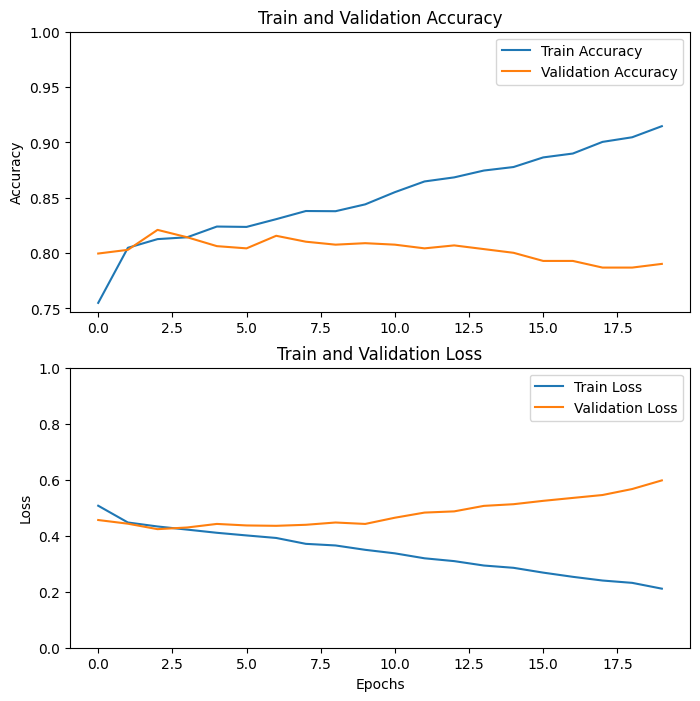

In [14]:
draw_learning_curve(history)

The base model achieved over 80% accuracy on both train set and validation set. Though there are a clear gap between learning curve on train and validation, which is a sign of overfitting.

In [15]:
# store the performance of base model for later comparision
baseline_model = {'Name': 'Base Model', 
                  'Accuracy': history.history['accuracy'][-1],
                  'Val_Accuracy': history.history['val_accuracy'][-1],
                  'Loss': history.history['loss'][-1],
                  'Val_Loss': history.history['val_loss'][-1]}
model_results = [baseline_model]

In [16]:
model_results

[{'Name': 'Base Model',
  'Accuracy': 0.9146626591682434,
  'Val_Accuracy': 0.7902471423149109,
  'Loss': 0.2109106183052063,
  'Val_Loss': 0.5976014733314514}]

## Improve Base Model

Model 2 we will try a more complex architecture.


In [17]:
model2 = Sequential()
model2.add(Input(shape = (data.shape[1],))),
model2.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=data.shape[1], trainable=False))
model2.add(Bidirectional(LSTM(units=256, dropout=0.2, recurrent_dropout=0.2,return_sequences = True)))
model2.add(Bidirectional(LSTM(units=256, dropout=0.2, recurrent_dropout=0.2)))
model2.add(Dense(units=100, activation='relu', kernel_regularizer=l2(0.001)))
model2.add(Dense(units=1, activation='sigmoid', kernel_regularizer=l2(0.001)))
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 24, 300)        │     5,046,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 24, 512)        │     1,140,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 512)            │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,813,349 (29.81 MB)

 Trainable params: 2,767,049 (10.56 MB)

 Non-trainable params: 5,046,300 (19.25 MB)

In [18]:
%%time
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history2 = model2.fit(
    data, 
    np.array(targets), 
    epochs=20, 
    batch_size=64, 
    validation_split=0.2, 
#     callbacks=[early_stopping]
)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 43s 374ms/step - accuracy: 0.7301 - loss: 0.6630 - val_accuracy: 0.8143 - val_loss: 0.4723
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 34s 361ms/step - accuracy: 0.8095 - loss: 0.4820 - val_accuracy: 0.8076 - val_loss: 0.4672
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 366ms/step - accuracy: 0.8076 - loss: 0.4476 - val_accuracy: 0.8009 - val_loss: 0.4531
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 36s 379ms/step - accuracy: 0.8239 - loss: 0.4272 - val_accuracy: 0.8056 - val_loss: 0.4390
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 372ms/step - accuracy: 0.8271 - loss: 0.4078 - val_accuracy: 0.7882 - val_loss: 0.4867
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 378ms/step - accuracy: 0.8207 - loss: 0.4058 - val_accuracy: 0.8036 - val_loss: 0.4611
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 376ms/step - accuracy: 0.8376 - loss: 0.3761 - val_accuracy: 0.7976 - val_loss: 0.4477
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 374ms/step - accuracy: 0.8531 - loss: 0.3461 - val_accu

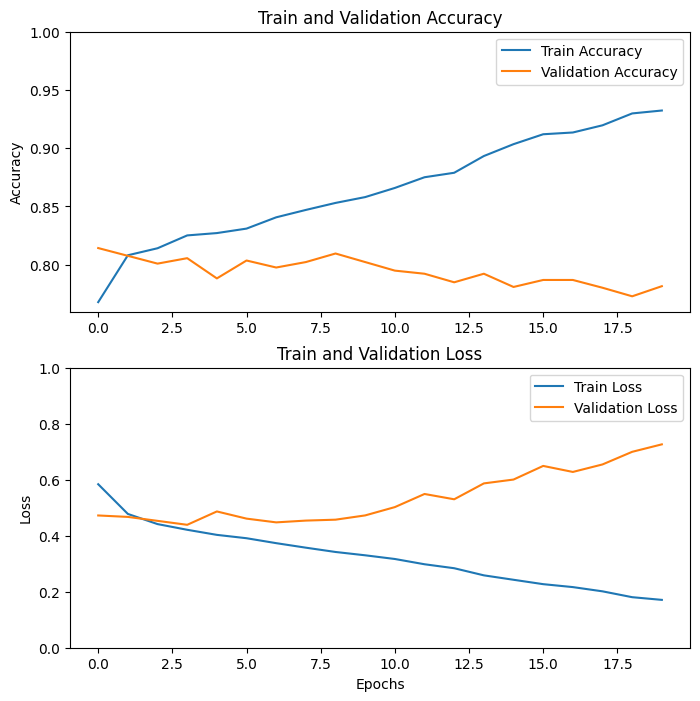

In [19]:
draw_learning_curve(history2)

In [20]:
model2_result = {'Name': 'Model With Dual LSTM', 
                  'Accuracy': history2.history['accuracy'][-1],
                  'Val_Accuracy': history2.history['val_accuracy'][-1],
                  'Loss': history2.history['loss'][-1],
                  'Val_Loss': history2.history['val_loss'][-1]}
model_results.append(model2_result)


In [21]:
model_results

[{'Name': 'Base Model',
  'Accuracy': 0.9146626591682434,
  'Val_Accuracy': 0.7902471423149109,
  'Loss': 0.2109106183052063,
  'Val_Loss': 0.5976014733314514},
 {'Name': 'Model With Dual LSTM',
  'Accuracy': 0.9323647022247314,
  'Val_Accuracy': 0.7815631031990051,
  'Loss': 0.1708938628435135,
  'Val_Loss': 0.7263233065605164}]

In [54]:
# model3 = Sequential()
# model3.add(Input(shape = (data.shape[1],))),
# model3.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=data.shape[1], trainable=False))
# model3.add(Bidirectional(LSTM(units=256, dropout=0.2, recurrent_dropout=0.2,return_sequences = True)))
# model3.add(Bidirectional(LSTM(units=256, dropout=0.2, recurrent_dropout=0.2)))
# model3.add(Dense(units=100, activation='relu', kernel_regularizer=l2(0.001)))
# model3.add(Dropout(0.5)) 
# model3.add(Dense(units=1, activation='sigmoid', kernel_regularizer=l2(0.001)))
# model3.summary()
model3 = Sequential()
model3.add(Input(shape = (data.shape[1],))),
model3.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=data.shape[1], trainable=False))
model3.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model3.add(BatchNormalization())
model3.add(Dense(units=1, activation='sigmoid'))
model3.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 24, 300)        │     5,046,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 128)            │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,266,589 (20.09 MB)

 Trainable params: 220,033 (859.50 KB)

 Non-trainable params: 5,046,556 (19.25 MB)

In [55]:
%%time
model3.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history3 = model3.fit(
    data, 
    np.array(targets), 
    epochs=40, 
    batch_size=64, 
    validation_split=0.2, 
    callbacks=[early_stopping]
)

Epoch 1/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7241 - loss: 0.5779 - val_accuracy: 0.7047 - val_loss: 0.6068
Epoch 2/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8015 - loss: 0.4503 - val_accuracy: 0.7909 - val_loss: 0.5462
Epoch 3/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8151 - loss: 0.4211 - val_accuracy: 0.8016 - val_loss: 0.4951
Epoch 4/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8252 - loss: 0.3953 - val_accuracy: 0.8083 - val_loss: 0.4538
Epoch 5/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8444 - loss: 0.3734 - val_accuracy: 0.8056 - val_loss: 0.4483
Epoch 6/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8382 - loss: 0.3735 - val_accuracy: 0.7956 - val_loss: 0.4489
Epoch 7/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8421 - loss: 0.3566 - val_accuracy: 0.8069 - val_loss: 0.4443
Epoch 8/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8566 - loss: 0.3317 - val_accuracy: 0.8036 - v

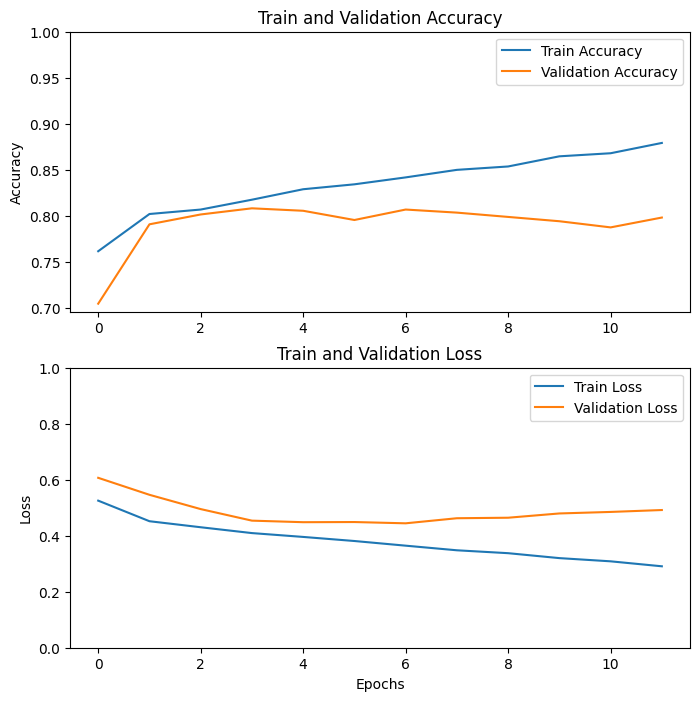

In [56]:
draw_learning_curve(history3)

In [57]:
model3_result = {'Name': 'Base Model With Batch Norm', 
                  'Accuracy': history3.history['accuracy'][-1],
                  'Val_Accuracy': history3.history['val_accuracy'][-1],
                  'Loss': history3.history['loss'][-1],
                  'Val_Loss': history3.history['val_loss'][-1]}
model_results.append(model3_result)

Let's try transformer!

reload data

In [58]:
X, y = train['text'], train['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
preset = "bert_base_en_uncased"

preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    preset=preset,
    sequence_length=160
)

classifier = keras_nlp.models.BertClassifier.from_preset(
    preset=preset,
    preprocessor=preprocessor,
    num_classes=2
)

classifier.summary()

Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 768), (None,      │     109,482,240 │ padding_mask[0][0],        │
│                               │ None, 768)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 109,483,778 (417.65 MB)

 Trainable params: 109,483,778 (417.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
classifier.compile(
    loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics=["accuracy"]
)

history4 = classifier.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    
)

Epoch 1/10


In [ ]:
draw_learning_curve(history4)

In [ ]:
y_train_pred = classifier.predict(X_train)

In [ ]:
def draw_confusion_matrix(y, y_pred)
    display = ConfusionMatrixDisplay.from_predictions(
        y,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster", "Disaster"],
        cmap=plt.cm.Blues
    )
    display.ax_.set_title("Confusion Matrix: Training Dataset")

    tn, fp, fn, tp = confusion_matrix(y_train, np.argmax(y_train_pred, axis=1)).ravel()
    f1_score = tp / (tp + (fp + fn) / 2)
    print("F1 score:", f1_score)

In [ ]:
draw_confusion_matrix(y_train, y_train_pred)

In [ ]:
y_val_pred = classifier.predict(X_val)
draw_confusion_matrix(y_val, y_val_pred)

# Results and Analysis

 Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

In [ ]:
def submit(final_model):
    

 # Conclusion

 Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

# Reference

* https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
* https://medium.com/@manansuri/a-dummys-guide-to-word2vec-456444f3c673
* https://en.wikipedia.org/wiki/Word2vec
* https://keras.io/guides/keras_nlp/getting_started/
* https://www.kaggle.com/code/josephtk/disaster-tweets-classification-using-bert
* https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets
* https://www.kaggle.com/code/tuckerarrants/disaster-tweets-eda-glove-rnns-bert